In [1]:
import pandas as pd
import requests, zipfile, io

response = requests.get('https://apps.fas.usda.gov/psdonline/downloads/psd_coffee_csv.zip')
zf = zipfile.ZipFile(io.BytesIO(response.content))
usda = pd.read_csv(zf.open('psd_coffee.csv'))

In [2]:
usda.head()

,Commodity_Code,Commodity_Description,Country_Code,Country_Name,Market_Year,Calendar_Year,Month,Attribute_ID,Attribute_Description,Unit_ID,Unit_Description,Value
0,711100,"Coffee, Green",AG,Algeria,2003,2012,6,29,Arabica Production,2,(1000 60 KG BAGS),0.0
1,711100,"Coffee, Green",AG,Algeria,2003,2012,6,90,Bean Exports,2,(1000 60 KG BAGS),0.0
2,711100,"Coffee, Green",AG,Algeria,2003,2012,6,58,Bean Imports,2,(1000 60 KG BAGS),1800.0
3,711100,"Coffee, Green",AG,Algeria,2003,2012,6,20,Beginning Stocks,2,(1000 60 KG BAGS),0.0
4,711100,"Coffee, Green",AG,Algeria,2003,2012,6,125,Domestic Consumption,2,(1000 60 KG BAGS),1805.0


In [4]:
def country_query(country, year_type='Market_Year', attribute=''):
    df = usda[usda['Country_Name'] == country]
    if attribute:
        df = df[df['Attribute_Description'] == attribute]
    return df.pivot(
        index='Attribute_Description', 
        columns=year_type, 
        values='Value'
    )

country_query('Guatemala', attribute='Arabica Production')

Market_Year,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Attribute_Description,,,,,,,,,,,,,,,,,,,,,
Arabica Production,1500.0,1700.0,1929.0,1712.0,1660.0,2095.0,1726.0,1792.0,1716.0,1941.0,...,4000.0,3950.0,4400.0,4000.0,3500.0,3125.0,3125.0,3400.0,3600.0,3700.0


In [5]:
def attribute_query(attribute, year_type='Market_Year', countries=[]):
    df = usda[usda['Attribute_Description'] == attribute]
    if countries:
        df = df[df['Country_Name'].isin(countries)]
    return df.pivot(
        index='Country_Name', 
        columns=year_type, 
        values='Value'
    )

attribute_query('Arabica Production', countries=['Guatemala', 'Honduras', 'Nicaragua'])

Market_Year,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Country_Name,,,,,,,,,,,,,,,,,,,,,
Guatemala,1500.0,1700.0,1929.0,1712.0,1660.0,2095.0,1726.0,1792.0,1716.0,1941.0,...,4000.0,3950.0,4400.0,4000.0,3500.0,3125.0,3125.0,3400.0,3600.0,3700.0
Honduras,291.0,315.0,405.0,390.0,479.0,461.0,431.0,495.0,514.0,443.0,...,3550.0,3975.0,5600.0,4725.0,4400.0,5100.0,5300.0,7510.0,7600.0,7600.0
Nicaragua,437.0,432.0,535.0,533.0,610.0,513.0,421.0,556.0,504.0,563.0,...,1925.0,1740.0,2100.0,1925.0,2000.0,2100.0,2100.0,2600.0,2700.0,2500.0


## Part 2

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

# Some constant assumptions we'll use in our analysis
YEARS_IN_SERIES = 25
MAJOR_PRODUCER_THRESHOLD = 5000  # thousands of bags
MIDSIZE_PRODUCER_THRESHOLD = 500 # thousands of bags

In [7]:
def is_producing_above(country_data, threshold_value, num_years_back=5):
    recent_production = country_data.iloc[0,-num_years_back:]
    production_peak = recent_production.mean()
    return production_peak > threshold_value

list_of_all_countries = usda['Country_Name'].unique()
major_producers = []
midsize_producers = []
minor_producers = []

for country in list_of_all_countries:
    country_series = country_query(country, attribute='Production')
    if is_producing_above(country_series, MAJOR_PRODUCER_THRESHOLD):
        major_producers.append(country)
    elif is_producing_above(country_series, MIDSIZE_PRODUCER_THRESHOLD):
        midsize_producers.append(country)
    elif is_producing_above(country_series, 0):
        minor_producers.append(country)
        
print("Major producers:", major_producers)
print("Midsize producers:", len(midsize_producers))
print("Minor producers:", len(minor_producers))

Major producers: ['Brazil', 'Colombia', 'Ethiopia', 'Honduras', 'India', 'Indonesia', 'Vietnam']
Midsize producers: 16
Minor producers: 25


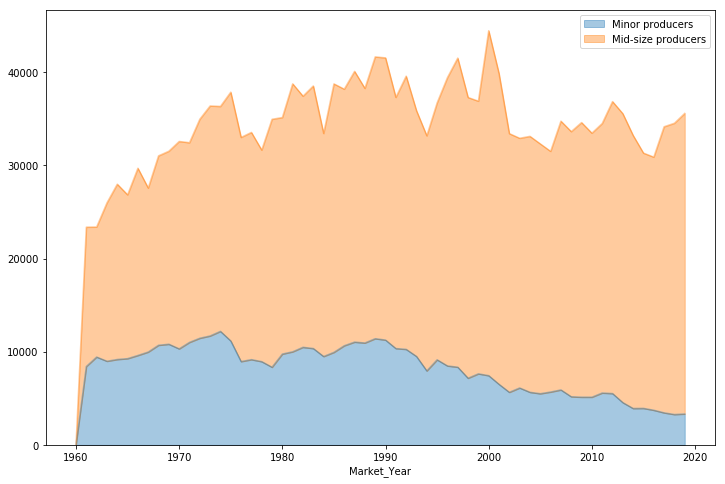

In [8]:
minor_producers_volumes = attribute_query('Production', countries=minor_producers).sum()
midsize_producers_volumes = attribute_query('Production', countries=midsize_producers).sum()
other_producers_volumes = pd.DataFrame(
    data=[minor_producers_volumes, midsize_producers_volumes], 
    index=['Minor producers', 'Mid-size producers']
)
other_producers_volumes.T.plot(kind='area', stacked=True, figsize=(12,8), alpha=.4)

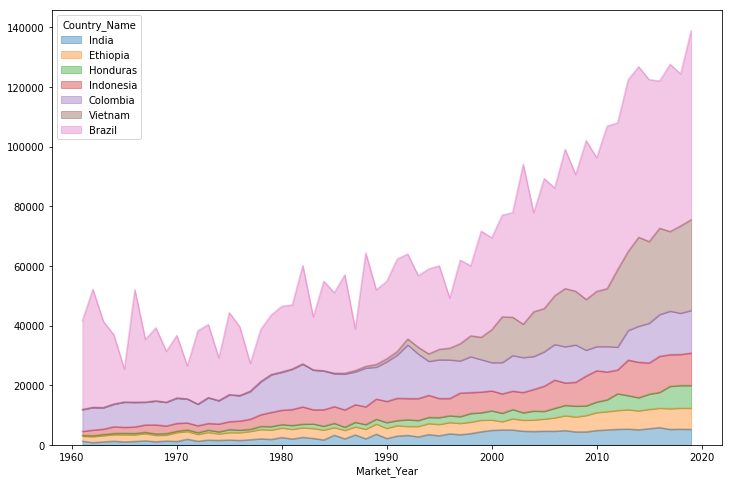

In [9]:
major_producers_volumes = attribute_query('Production', countries=major_producers)
major_producers_volumes = major_producers_volumes.sort_values(2019)
major_producers_volumes.T.plot(kind='area', stacked=True, figsize=(12,8), alpha=.4)

In [10]:
production_table = pd.concat([other_producers_volumes, major_producers_volumes], axis=0)
production_table = production_table.iloc[:,-YEARS_IN_SERIES:]
production_table = production_table.T
production_table

,Minor producers,Mid-size producers,India,Ethiopia,Honduras,Indonesia,Colombia,Vietnam,Brazil
Market_Year,,,,,,,,,
1995,9135.0,27585.0,3060.0,3800.0,2295.0,6400.0,13000.0,3500.0,28000.0
1996,8478.0,30958.0,3717.0,3800.0,2254.0,5800.0,12939.0,3917.0,16800.0
1997,8343.0,33189.0,3417.0,3800.0,2279.0,7900.0,10779.0,5750.0,28000.0
1998,7156.0,30145.0,3805.0,3833.0,2905.0,7000.0,12043.0,7000.0,23500.0
1999,7628.0,29280.0,4415.0,3867.0,2494.0,6950.0,10868.0,7500.0,35600.0
2000,7434.0,37037.0,4870.0,3505.0,3067.0,6660.0,9512.0,11010.0,30800.0
2001,6504.0,33367.0,5020.0,2768.0,2821.0,6495.0,10500.0,15333.0,34100.0
2002,5644.0,27778.0,5010.0,3756.0,3098.0,6160.0,11950.0,12833.0,35100.0
2003,6111.0,26813.0,4588.0,3693.0,2496.0,6800.0,11712.0,11167.0,53600.0


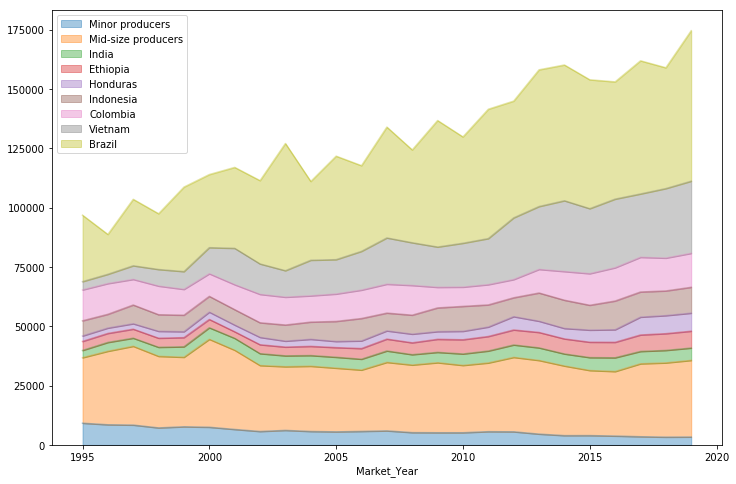

In [11]:
production_table.plot(kind='area', stacked=True, figsize=(12,8), alpha=.4)

Text(0.5, 0, 'Crop Year')

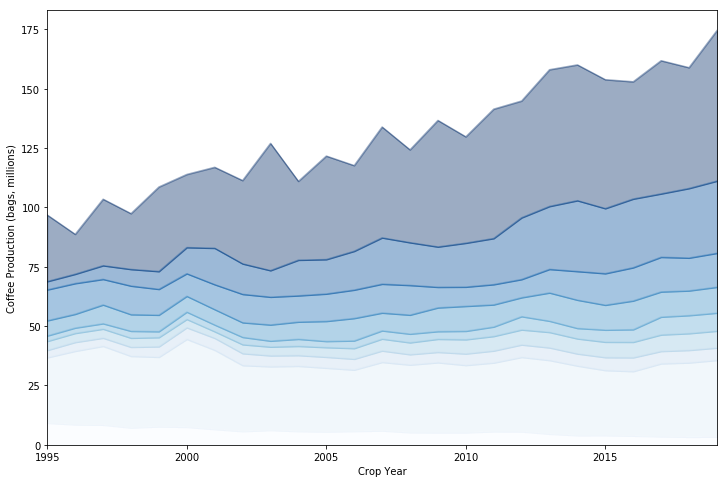

In [12]:
production_table /= 1000     # change to millions instead of thousands of bags

fig, ax = plt.subplots()
production_table.plot(
    kind='area', 
    stacked=True, 
    figsize=(12,8), 
    alpha=0.4, 
    colormap='Blues', 
    legend=False, 
    ax=ax
)

ax.set_ylabel("Coffee Production (bags, millions)")

# tighten up the x-axis
max_year = production_table.index[-1]
ax.set_xlim(max_year-YEARS_IN_SERIES+1, max_year)
ax.set_xlabel("Crop Year")

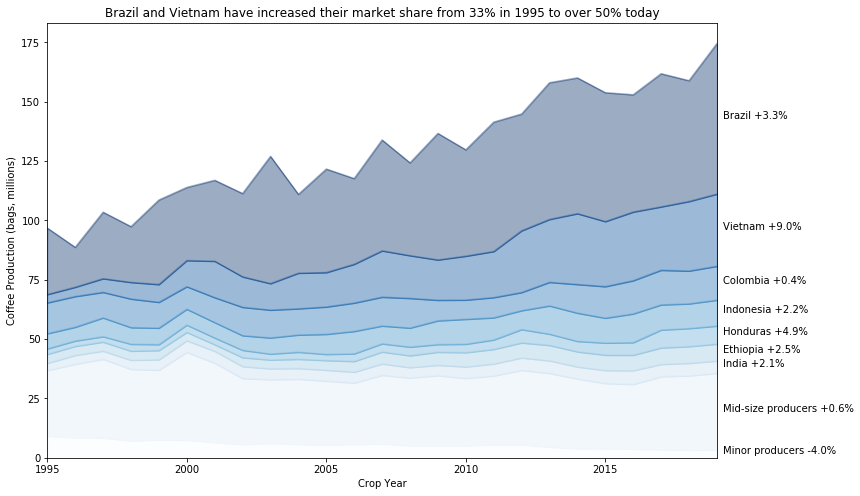

In [13]:
def cagr(series):
    start_val = series.iloc[0]
    end_val = series.iloc[-1]
    num_vals = len(series)
    CAGR = (end_val/start_val)**(1/num_vals)-1
    
    prefix = ''
    if CAGR > 0:
        prefix = '+'
    return prefix + '{:.1%}'.format(CAGR)


labels = []
y_vals = []
cum_sum = 0
for col_num, country_name in enumerate(production_table.columns):
    label = country_name + " " + cagr(production_table[country_name])
    labels.append(label)
    prod_val = production_table.iloc[-1,col_num]
    y_vals.append((cum_sum * 2 + prod_val)/2)
    cum_sum += prod_val

for i, label in enumerate(labels):
    ax.text(x=2019.2, y=y_vals[i], s=label)    
    
ax.set_title("Brazil and Vietnam have increased their market share from 33% in 1995 to over 50% today")    

fig    